In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

In [2]:
import numpy as np

In [106]:
from scipy.spatial.distance import cdist


In [3]:
tensor_train_x = torch.linspace(0, 1, 100)

tensor_train_y = torch.stack([
    torch.sin(tensor_train_x * (2 * math.pi)) + torch.randn(tensor_train_x.size()) * 0.001,
    torch.cos(tensor_train_x * (2 * math.pi)) + torch.randn(tensor_train_x.size()) * 0.001,
], -1)

train_x = tensor_train_x.numpy()
train_y = tensor_train_y.numpy()

In [4]:
tensor_train_y.shape

torch.Size([100, 2])

In [5]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=5/2, ard_num_dims=1), 
                                         ard_num_dims=1) +
            gpytorch.kernels.ConstantKernel(),
            num_tasks=train_y.shape[1], rank=1
        )


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)



In [6]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2,
                                                              has_global_noise=True, 
                                                              has_task_noise=False,
                                                              noise_constraint=gpytorch.constraints.LessThan(1e-8)
                                                             )
likelihood.noise = 1e-8  # Some small value, but don't make it too small or numerical performance will suffer. I recommend 1e-4.
likelihood.raw_noise.requires_grad_(False)  # Mark that we don't want to train the noise.

model = MultitaskGPModel(tensor_train_x, tensor_train_y, likelihood)

In [7]:
training_iterations = 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(tensor_train_x)
    loss = -mll(output, tensor_train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

/home/users/delon/.local/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/users/delon/.local/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


Iter 1/100 - Loss: -5.810
Iter 2/100 - Loss: -5.965
Iter 3/100 - Loss: -5.910
Iter 4/100 - Loss: -5.899
Iter 5/100 - Loss: -5.972
Iter 6/100 - Loss: -5.935
Iter 7/100 - Loss: -5.965
Iter 8/100 - Loss: -6.060
Iter 9/100 - Loss: -5.945
Iter 10/100 - Loss: -5.991
Iter 11/100 - Loss: -6.010
Iter 12/100 - Loss: -6.021
Iter 13/100 - Loss: -6.062
Iter 14/100 - Loss: -6.001
Iter 15/100 - Loss: -6.010
Iter 16/100 - Loss: -5.938
Iter 17/100 - Loss: -5.984
Iter 18/100 - Loss: -5.997
Iter 19/100 - Loss: -5.977
Iter 20/100 - Loss: -5.960
Iter 21/100 - Loss: -6.011
Iter 22/100 - Loss: -5.988
Iter 23/100 - Loss: -5.969
Iter 24/100 - Loss: -6.003
Iter 25/100 - Loss: -5.545
Iter 26/100 - Loss: -5.987
Iter 27/100 - Loss: -5.571
Iter 28/100 - Loss: -5.531
Iter 29/100 - Loss: -5.650
Iter 30/100 - Loss: -5.611
Iter 31/100 - Loss: -5.637
Iter 32/100 - Loss: -5.608
Iter 33/100 - Loss: -5.666
Iter 34/100 - Loss: -5.641
Iter 35/100 - Loss: -5.676
Iter 36/100 - Loss: -5.584
Iter 37/100 - Loss: -5.641
Iter 38/10

/home/users/delon/.local/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


Text(0.5, 1.0, 'Observed Values (Likelihood)')

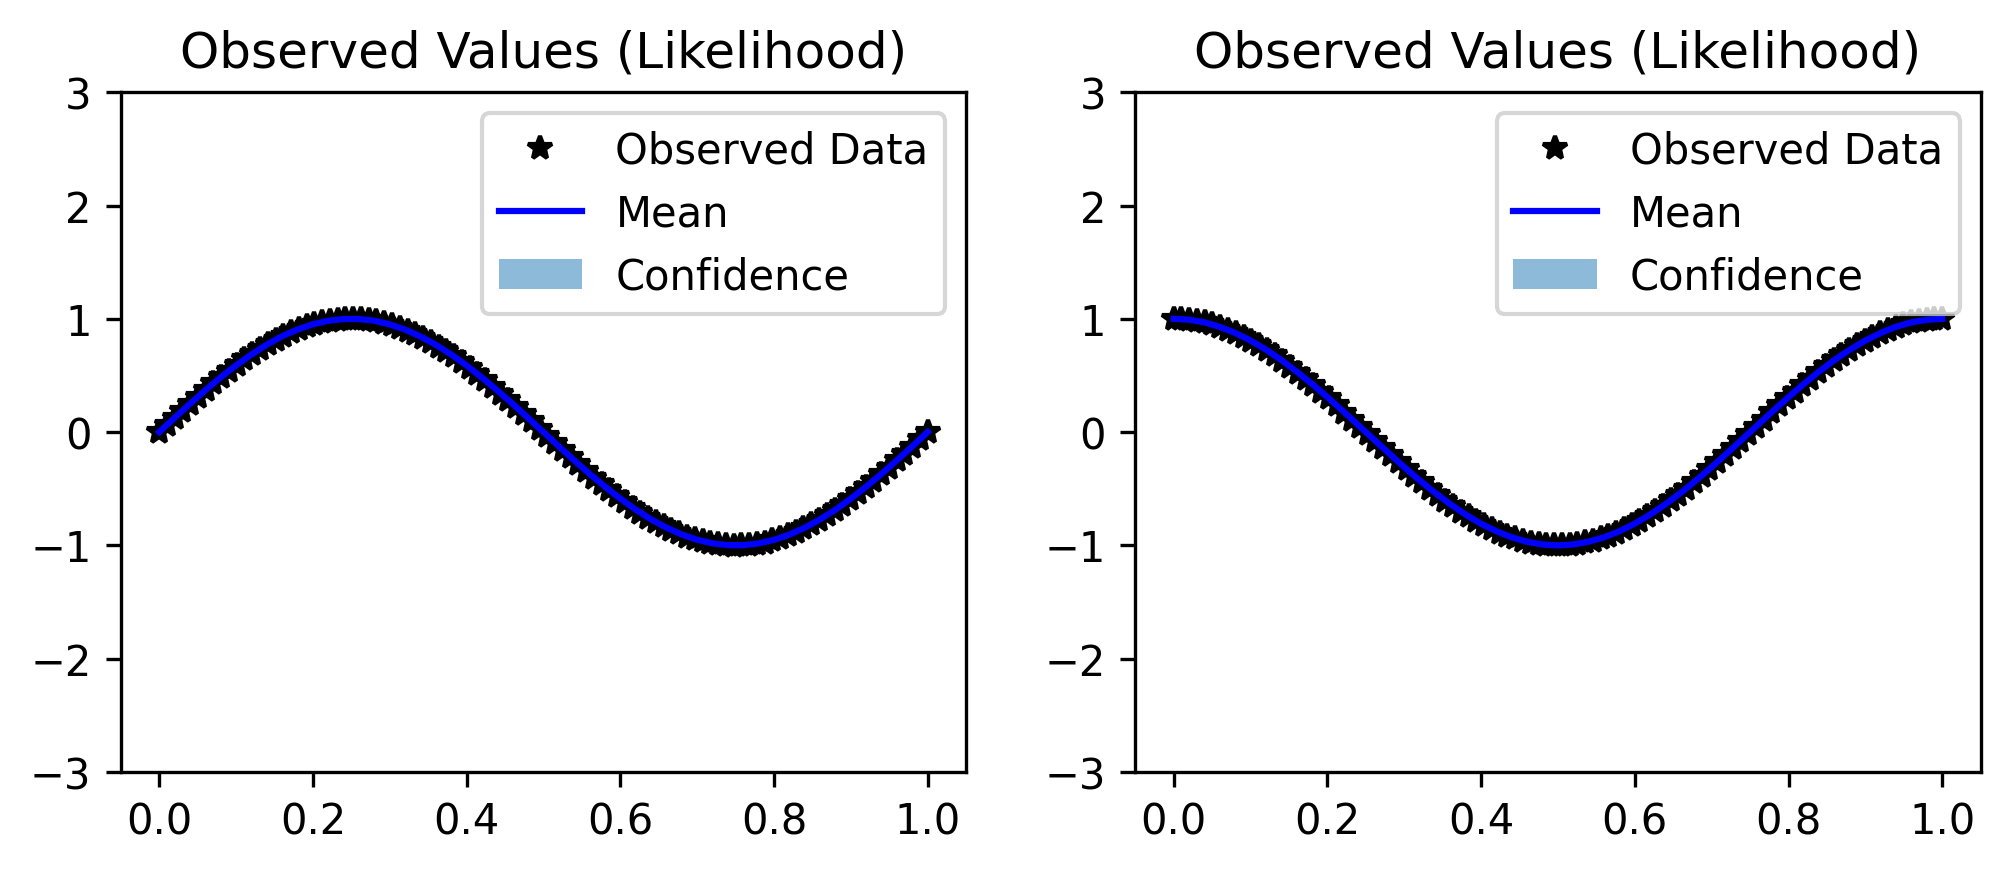

In [8]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = model(test_x)
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x, train_y[:, 0], 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x, mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x, lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x, train_y[:, 1], 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x, mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x, lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

In [124]:
tensor_test_x = torch.tensor(test_x)

/tmp/ipykernel_22013/3250234862.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_test_x = torch.tensor(test_x)


In [9]:
model.state_dict()

OrderedDict([('likelihood.raw_noise', tensor([inf])),
             ('likelihood.raw_noise_constraint.lower_bound', tensor(-inf)),
             ('likelihood.raw_noise_constraint.upper_bound',
              tensor(1.0000e-08)),
             ('mean_module.base_means.0.raw_constant', tensor(0.0161)),
             ('mean_module.base_means.1.raw_constant', tensor(0.2741)),
             ('covar_module.task_covar_module.covar_factor',
              tensor([[-0.0417],
                      [ 0.0432]])),
             ('covar_module.task_covar_module.raw_var',
              tensor([-2.3379, -2.4467])),
             ('covar_module.task_covar_module.raw_var_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.task_covar_module.raw_var_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.data_covar_module.kernels.0.raw_outputscale',
              tensor(2.9411)),
             ('covar_module.data_covar_module.kernels.0.base_kernel.raw_lengthscale

In [59]:
class numpy_ScaleKernel():
    def __init__(self, base_kernel, scale):
        self.base_kernel = base_kernel
        self.scale = scale
    
    def __call__(self, x1, x2 = None):
        if(x2 is None):
            x2 = x1
        return self.base_kernel(x1, x2)*self.scale
    
    
class numpy_ConstantMean():
    def __init__(self, raw_constant):
        self.constant = raw_constant
    def __call__(self, input):
        return self.constant * np.ones_like(input)


In [15]:
model.covar_module.task_covar_module.var

tensor([0.0922, 0.0830], grad_fn=<SoftplusBackward0>)

In [108]:
class numpy_IndexKernel():
    def __init__(self, num_tasks, covar_factor, var):
        self.num_tasks = num_tasks 
        self.covar_factor = covar_factor
        self.var = var
        self.covar_matrix = self.covar_factor@self.covar_factor.T + np.diag(self.var)
        

    def __call__(self, i1, i2):
        return self.covar_matrix[i1, i2]
        
class numpy_ConstantKernel():
    def __init__(self, const):
        self.const = const
    
    def __call__(self, x1, x2 = None):
        return self.const
    
class numpy_AdditiveKernel():
    def __init__(self, kernel_A, kernel_B):
        self.kernel_A = kernel_A
        self.kernel_B = kernel_B
        
    def __call__(self, x1, x2 = None):
        if(x2 is None):
            x2 = x1
        
        return self.kernel_A(x1, x2) + self.kernel_B(x1, x2)
        
        
class numpy_MultitaskKernel():
    def __init__(self,
                 num_tasks,
                 task_covar_module,
                data_covar_module):
        self.task_covar_module = task_covar_module
        self.data_covar_module = data_covar_module
        self.num_tasks = num_tasks
    
    def __call__(self, x1, x2 = None):
        if(x2 is None):
            x2 = x1
        covar_i = self.task_covar_module.covar_matrix
        covar_x = self.data_covar_module(x1, x2)
        res = np.kron(covar_x, covar_i)
        return res

In [113]:
model.covar_module.task_covar_module.var.detach().numpy()

array([0.09215076, 0.08303541], dtype=float32)

In [114]:
model.covar_module.task_covar_module.covar_factor.detach().numpy()

array([[-0.04166456],
       [ 0.04318596]], dtype=float32)

In [115]:
my_IndexKernel = numpy_IndexKernel(
    2, 
    model.covar_module.task_covar_module.covar_factor.detach().numpy(),
    model.covar_module.task_covar_module.var.detach().numpy())
np.allclose(my_IndexKernel.covar_matrix, model.covar_module.task_covar_module.covar_matrix.detach().numpy())

True

In [116]:
class numpy_MaternKernel():
    def __init__(self, nu, lengthscale):
        self.nu = nu
        self.lengthscale = lengthscale 
    def __call__(self, x1, x2 = None):
        _x1 = x1 / self.lengthscale
        
        if(x2 is None):
            x2 = x1

        _x2 = x2 / self.lengthscale
        

        if(len(x1.shape) == 1): #handle 1d data
            _x1 = np.expand_dims(x1, axis=1) / self.lengthscale
            _x2 = np.expand_dims(x2, axis=1) / self.lengthscale
            
        distance = cdist(_x1, _x2, 'minkowski', p=2)
        
        exp_component = np.exp(-np.sqrt(self.nu * 2.) * distance)

        if self.nu == 0.5:
            constant_component = 1
        elif self.nu == 1.5:
            constant_component = (np.sqrt(3) * distance) + 1.
        elif self.nu == 2.5:
            constant_component = (np.sqrt(5) * distance)+ 1. + (5/3 * distance**2)
        
        return constant_component * exp_component


In [117]:
model.covar_module.data_covar_module.kernels

ModuleList(
  (0): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
  (1): ConstantKernel(
    (raw_constant_constraint): Positive()
  )
)

In [118]:
my_ConstantKernel = numpy_ConstantKernel(model.covar_module.data_covar_module.kernels[1].constant.item())
my_MaternKernel = numpy_MaternKernel(nu = 5/2, lengthscale = model.covar_module.data_covar_module.kernels[0].base_kernel.lengthscale.item())
my_ScaleKernel  = numpy_ScaleKernel(my_MaternKernel, model.covar_module.data_covar_module.kernels[0].outputscale.item())
my_AdditiveKernel = numpy_AdditiveKernel(my_ScaleKernel, my_ConstantKernel)

In [119]:
my_MultiKernel = numpy_MultitaskKernel(
    num_tasks = 2,
    task_covar_module = my_IndexKernel,
    data_covar_module = my_AdditiveKernel)

In [120]:
my_MultiKernel(train_x, test_x)

array([[ 0.29823174, -0.00571557,  0.29786975, ..., -0.00116174,
         0.0581515 , -0.00111446],
       [-0.00571557,  0.26968683, -0.00570863, ...,  0.05481645,
        -0.00111446,  0.05258559],
       [ 0.29813928, -0.00571379,  0.29814294, ..., -0.00118656,
         0.05938161, -0.00113804],
       ...,
       [-0.00113804,  0.05369797, -0.00118656, ...,  0.26960653,
        -0.00571379,  0.26960322],
       [ 0.0581515 , -0.00111446,  0.06061848, ..., -0.00570863,
         0.29823174, -0.00571557],
       [-0.00111446,  0.05258559, -0.00116174, ...,  0.26935949,
        -0.00571557,  0.26968683]])

In [127]:
model.covar_module(tensor_train_x, tensor_test_x).detach().numpy()

array([[ 0.29823175, -0.00571557,  0.29786977, ..., -0.00116174,
         0.0581515 , -0.00111446],
       [-0.00571557,  0.26968685, -0.00570863, ...,  0.05481647,
        -0.00111446,  0.05258559],
       [ 0.29813927, -0.00571379,  0.29814294, ..., -0.00118656,
         0.05938161, -0.00113804],
       ...,
       [-0.00113804,  0.05369796, -0.00118656, ...,  0.26960653,
        -0.00571379,  0.26960322],
       [ 0.0581515 , -0.00111446,  0.06061848, ..., -0.00570863,
         0.29823175, -0.00571557],
       [-0.00111446,  0.05258559, -0.00116174, ...,  0.26935947,
        -0.00571557,  0.26968685]], dtype=float32)

In [131]:
np.allclose(my_MultiKernel(train_x, test_x), 
            model.covar_module(tensor_train_x, tensor_test_x).detach().numpy(),
           atol = 0, rtol = 1e-6)

True

In [144]:
model.mean_module(tensor_test_x).shape

torch.Size([51, 2])

In [168]:

from copy import deepcopy

class numpy_ConstantMean():
    def __init__(self, raw_constant):
        self.constant = raw_constant
    def __call__(self, input):
        return self.constant * np.ones_like(input)

class numpy_MultitaskMean:
    def __init__(self, base_means):
        self.base_means = base_means
    
    def __call__(self, input):
        return np.vstack([base_mean(input) for base_mean in self.base_means]).T

In [169]:
my_ConstantMean_0 = numpy_ConstantMean(model.mean_module.base_means[0].constant.item())
my_ConstantMean_1 = numpy_ConstantMean(model.mean_module.base_means[1].constant.item())
my_MultiMean = numpy_MultitaskMean([my_ConstantMean_0, my_ConstantMean_1])

In [172]:
my_MultiMean(test_x).shape

(51, 2)

In [173]:
tmp_covar_module = my_MultiKernel
tmp_mean_module = my_MultiMean

In [175]:
import scipy

In [184]:
KXSX = tmp_covar_module(test_x, train_x)
KXSXS = tmp_covar_module(test_x, test_x)
KXXS = tmp_covar_module(train_x, test_x)
KXX = tmp_covar_module(train_x, train_x)
L = np.linalg.cholesky(KXX)

_y = train_y - tmp_mean_module(train_x)
_y = _y.flatten()

alpha = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, _y, lower=True))

my_predictive_mean = np.reshape(np.einsum('ij,j->i', KXSX, alpha), (len(test_x), 2))+ tmp_mean_module(test_x)


beta = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, KXXS, lower=True))


my_predictive_cov = KXSXS - np.einsum('ij,jk->ik', KXSX, beta)

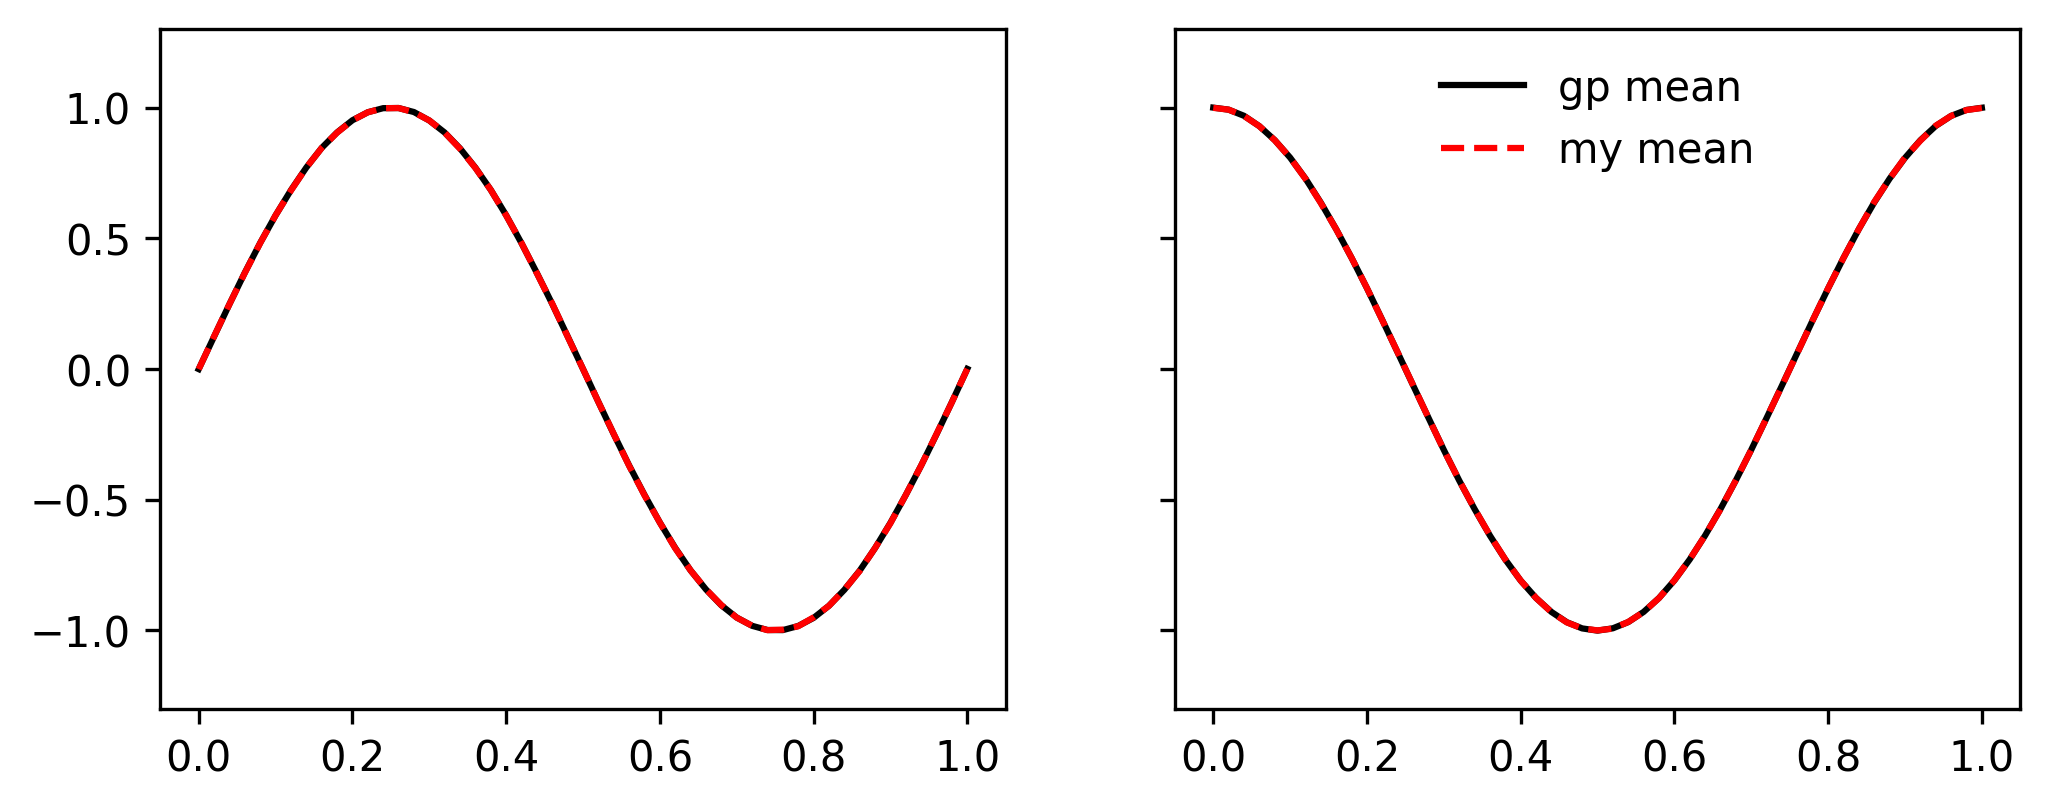

In [195]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3), dpi=300, sharey = True)

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = model(test_x)
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# Predictive mean as blue line
y1_ax.plot(test_x, mean[:, 0].numpy(), 'k', label='gp mean')
y1_ax.plot(test_x, my_predictive_mean[:, 0], 'r--', label='my mean')

# Predictive mean as blue line
y2_ax.plot(test_x, mean[:, 1].numpy(), 'k', label='gp mean')
y2_ax.plot(test_x, my_predictive_mean[:, 1], 'r--', label='my mean')

y2_ax.set_ylim([-1.3, 1.3])
plt.legend(frameon=False)